In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np

### Récupération des données des csv

In [2]:
def InitialisationDataTrain():
    data = pd.read_csv('Train/X_train.txt', sep=" ", header=None)
    Y = pd.read_csv('Train/y_train.txt', sep=" ", header=None)
    Y.columns = ["resultat"]
    return data, Y
data, Y = InitialisationDataTrain()

def InitialisationDataTest():
    dataTest = pd.read_csv('Test/X_test.txt', sep=" ", header=None)
    Y_test = pd.read_csv('Test/y_test.txt', sep=" ", header=None)
    Y_test.columns = ["resultat"]
    return dataTest, Y_test
dataTest, Y_test = InitialisationDataTest()

## Fonction Globale De Traitement Des Données 

tBodyAcc-ropy-1
tGravityAcc-ropy-1
tBodyAccJerk-ropy-1
tBodyGyro-ropy-1
tBodyGyroJerk-ropy-1
fBodyAcc-ropy-1
fBodyAcc-Skewness-1
fBodyAcc-Kurtosis-1
fBodyAccJerk-ropy-1
fBodyAccJerk-Skewness-1
fBodyAccJerk-Kurtosis-1
fBodyGyro-ropy-1
fBodyGyro-Skewness-1
fBodyGyro-Kurtosis-1
7767
Variable avec la meilleure Corrélation : 
                nomVariable  Correlation
324      fBodyAccJerk-STD-2        0.639
81       tBodyAccJerk-Mad-2        0.638
86       tBodyAccJerk-Min-1        0.638
330      fBodyAccJerk-Max-2        0.636
94       tBodyAccJerk-IQR-2        0.635
211  tBodyAccJerkMag-Mean-1        0.634
47        tGravityAcc-Max-2        0.634


<IPython.core.display.Javascript object>


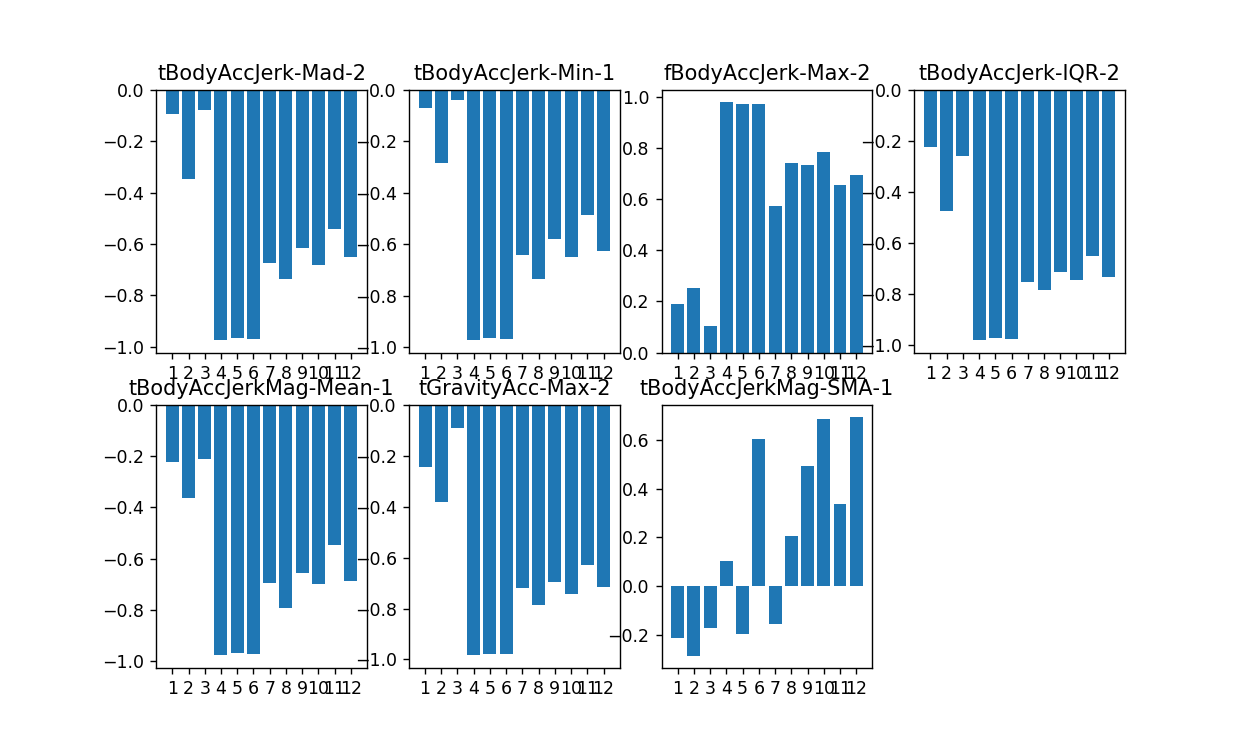

2
3
4
5
6
7
8
tBodyAcc-ropy-1
tGravityAcc-ropy-1
tBodyAccJerk-ropy-1
tBodyGyro-ropy-1
tBodyGyroJerk-ropy-1
fBodyAcc-ropy-1
fBodyAcc-Skewness-1
fBodyAcc-Kurtosis-1
fBodyAccJerk-ropy-1
fBodyAccJerk-Skewness-1
fBodyAccJerk-Kurtosis-1
fBodyGyro-ropy-1
fBodyGyro-Skewness-1
fBodyGyro-Kurtosis-1
3162
Variable avec la meilleure Corrélation : 
                nomVariable  Correlation
324      fBodyAccJerk-STD-2        0.639
81       tBodyAccJerk-Mad-2        0.638
86       tBodyAccJerk-Min-1        0.638
330      fBodyAccJerk-Max-2        0.636
94       tBodyAccJerk-IQR-2        0.635
211  tBodyAccJerkMag-Mean-1        0.634
47        tGravityAcc-Max-2        0.634


In [19]:
def FonctionGlobaleTraitementData(data, Y, isTrain = True) :
    data = GestionDesDoublonsEtAjoutNomColonnes(data)
    data = AjoutVariableSujetId(data)
    data = AjoutDeLaTargetPrecedente(data, Y)
    corrSort, corrSortAAjouter = RecuperationDesVariablesAyantLesMeilleuresCorrelations()
    data = AjoutVariableLignePrecedente(corrSortAAjouter, data)
    if isTrain is True :
        RealisationDeGraph(corrSort, data)
    return data 
data = FonctionGlobaleTraitementData(data, Y)
dataTest = FonctionGlobaleTraitementData(dataTest, Y_test, isTrain= False)
# Sauvegarde Des Données permet de ne pas avoir à réexucuter la méthode
data.to_csv("DonneeNettoyee.csv")
dataTest.to_csv("DonneeTestNettoyee.csv")

### Liste des méthodes de nettoyage de la dataset et réalisation des graphes

In [15]:
# Récupération du nom des colonnes qui sont en doublon
def GestionDesDoublonsEtAjoutNomColonnes(df) :
    colonne = pd.read_csv('features.txt', sep="\n", header=None)
    listColonne = colonne.values.tolist()
    listCol = []
    doublon = []
    # Conversion des colonnes en string
    for index, row in colonne.iterrows() :
        if str(row[0]) in listCol :
            doublon.append(str(row[0]))
        listCol.append(str(row[0]))
    double, listColonne = SuppressionEspacesNomColonnes(doublon, listCol)
    df.columns = listColonne
    df = TraitementDesDoublons(df, double)
    return df
# Suppression des espaces présents à la fin du nom des colonnes et ajout du nom des colonnes à la dataframe
def SuppressionEspacesNomColonnes(doublon, listCol) : 
    double = []
    listColonne = []
    for element in doublon :
        double.append(element.replace(" ",""))
    for element in listCol :
        listColonne.append(element.replace(" ",""))
    return double, listColonne
# Traitement des doublons
def TraitementDesDoublons(df, double) :
    double = list(dict.fromkeys(double))
    df = df.astype(float)
    somme = 0
    nombre = 0
    for doublon in double : 
        result= []
        print(doublon)
        for index, row in df[doublon].iterrows() :
            for res in row :
                somme = somme + res
                nombre+=1
                # Rectification du nom des doublons
                text = doublon + "_" + str(nombre)
                df[text] = res
            result.append(somme/nombre)
            somme = 0
            nombre = 0
        # Ajout de la variable moyenne
        text = doublon +"_moyenne"
        df[text] = result
        df = df.drop(columns=[doublon])
    return df

# Ajout de la variable avec l'id du sujet étudié lors de cette mesure
def AjoutVariableSujetId(df, isTrain = True):
    nomFichier = 'Test/subject_id_test.txt'
    if isTrain is True :
        nomFichier = 'Train/subject_id_train.txt'
    subject_id_train = pd.read_csv(nomFichier, sep=" ", header=None)
    df["sujet_id"]= subject_id_train
    return df

# Ajout d'une variable avec la valeur de la Target précédente
def AjoutDeLaTargetPrecedente(df, Y) :
    dataPrecedent = Y["resultat"][0]
    df["target"] =Y["resultat"]
    utilisateurPrecedent = df["sujet_id"][0]
    valPrec = []
    for index, row in df.iterrows() :
        if utilisateurPrecedent == row["sujet_id"] :
            valPrec.append(dataPrecedent)
        else :
            valPrec.append(row["target"])
        dataPrecedent = row["target"]
    print(len(valPrec))
    df["targetPrecedent"] = valPrec
    return df

# Calcul de la corrélation entre les variables et la target
def RecuperationDesVariablesAyantLesMeilleuresCorrelations() :
    colnames=['nomVariable', 'Correlation']
    corr = pd.read_csv("Correlation.csv", names=colnames, header=None)
    corr["Correlation"] = abs(corr["Correlation"])
    # Récupération d'une valeur arrondie
    corr["Correlation"] = round(corr["Correlation"],3)
    corrSort = corr.sort_values(by=['Correlation'], ascending = False)
    print("Variable avec la meilleure Corrélation : ")
    print(corrSort[2:9])
    corrSortAAjouter = corrSort[2:3]
    return corrSort, corrSortAAjouter

# Ajout de la variable avec la meilleure corrélation de la ligne précédente
def AjoutVariableLignePrecedente(corrSortAAjouter, df):
    variableAjout = corrSortAAjouter.iloc[0]['nomVariable']
    varLignePrecedente=-1000
    tabDataLignePrecedente = []
    utilisateurPrecedent = df["sujet_id"][0]
    count = 0
    for index, row in df.iterrows() :
        if utilisateurPrecedent == row["sujet_id"] :
            tabDataLignePrecedente.append(varLignePrecedente)
        else :
            tabDataLignePrecedente.append(-1000)
        varLignePrecedente = row[variableAjout] 
    nomVariable = variableAjout + "_LignePrecedente"
    df[nomVariable] =tabDataLignePrecedente
    return df

# Réalisation de plusieurs graphes pour mieux appréhender la corrélation de certaines variables
def RealisationDeGraph(corrSort, df): 
    unique, moyenneAAfficher = MoyenneDesVariablesEnFonctionDeLaTarget(corrSort, df)
    AffichageDesGraphes(unique, moyenneAAfficher, corrSort)
    
def MoyenneDesVariablesEnFonctionDeLaTarget(corrSort, df):
    moyenneAAfficher = []
    inter = []
    for i in range(2,9):
        aAfficher = corrSort[i:i+1].iloc[0]['nomVariable']
        inter = df.groupby('target')[aAfficher].mean()
        moyenneAAfficher.append(inter)
    moyenne = df.groupby('target')['fBodyAccJerk-STD-2'].mean()
    unique = df["target"].unique()
    moyenneAAfficher[0]
    unique.sort()
    return unique, moyenneAAfficher

def AffichageDesGraphes(unique, moyenneAAfficher, corrSort) :
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib notebook
    y_pos = np.arange(len(unique))
    fig = plt.figure(2, figsize=(10, 6))
    count = 1
    for ligne in moyenneAAfficher :
        plt.subplot(2, 4, count)
        plt.bar(y_pos, ligne)
        variableEtudie = corrSort[2+count:3+count].iloc[0]['nomVariable']
        texte = "Moyenne de la variable " + variableEtudie + " pour chaque target"
        plt.title(variableEtudie)
        plt.xticks(y_pos, unique)
        count = count+1
        print(count)


    plt.show()

### Calcul de la corrélation entre les variables et la target (ne pas réexécuté, le résultat a déjà été sauvegardé) 

In [ ]:
import numpy as np
from matplotlib import pyplot
meilleurCor = data[data.columns[0:]].corr()['target'][:]
meilleurCor.to_csv("Correlation.csv")

### Prédiction du jeu de test avec plusieurs algorithmes et plusieurs paramétrage :

In [9]:
def RecuperationDataTrainEtTest():
    data = pd.read_csv('DonneeNettoyee.csv')
    print(data["target"].value_counts())
    dataTest = pd.read_csv('DonneeTestNettoyee.csv')
    X_train = data.drop(columns=["target", "targetPrecedent"])
    Y_train = data["target"]
    X_test = dataTest.drop(columns=["target", "targetPrecedent"])
    Y_test = dataTest["target"]
    return X_train, Y_train, X_test, Y_test
X_train, Y_train, X_test, Y_test = RecuperationDataTrainEtTest()

def PredictionTest(model, X_test, Y_test) :
    Y_pred = model.predict(X_test)
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(Y_pred, Y_test)
    print("MSE : %f" % (mse))
    from sklearn.metrics import accuracy_score
    Y_pred = [round(x) for x in Y_pred]
    accuracy = accuracy_score(Y_pred, Y_test)
    print("Précision : %f" % (accuracy))
    return mse, accuracy

5     1423
6     1413
4     1293
1     1226
2     1073
3      987
11      90
9       75
10      60
12      57
7       47
8       23
Name: target, dtype: int64


In [14]:
def PredictionModeleLineaire():
    from sklearn.linear_model import LinearRegression
    import pickle
    X_train, Y_train, X_test, Y_test = RecuperationDataTrainEtTest()
    modeleReg=LinearRegression()
    modelRegression = modeleReg.fit(X_train,Y_train)
    mse, accuracy = PredictionTest(modelRegression, X_test, Y_test)
    pickle.dump(modelRegression, open("API/modelRegressionLineaire.dat", "wb"))
PredictionModeleLineaire()

MSE : 0.543908
Précision : 0.670462


In [7]:
! pip install pickle

  ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [12]:
def PredictionRegressionLogistique() :
    from sklearn.linear_model import LogisticRegression
    import pickle
    X_train, Y_train, X_test, Y_test = RecuperationDataTrainEtTest()
    modeleLog=LogisticRegression(random_state=1)
    modelLogistic = modeleLog.fit(X_train,Y_train)
    mse, accuracy = PredictionTest(modelLogistic, X_test, Y_test)
    pickle.dump(modelLogistic, open("API/modelRegressionLogistic.dat", "wb"))
PredictionRegressionLogistique()

D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


MSE : 0.382669
Précision : 0.924099


In [49]:
def PredictionRegressionLogistiqueGridSearch() :
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
    X_train, Y_train, X_test, Y_test = RecuperationDataTrainEtTest()
    modeleLog=LogisticRegression(random_state=1)
    modeleLog_cv=GridSearchCV(modeleLog,grid,cv=10)
    modelLogistic = modeleLog_cv.fit(X_train,Y_train)
    mse, accuracy = PredictionTest(modelLogistic, X_test, Y_test)
PredictionRegressionLogistiqueGridSearch()

D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: Futur

D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: Futur

D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: Futur

D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: Futur

D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: Futur

D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: Futur

D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: Futur

D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Programmes\AnacondaPython\lib\site-packages\sklearn\linear_model\logistic.py:432: Futur

MSE : 0.368121
Précision : 0.915560


In [11]:
def PredictionRandomForest() :
    from sklearn.ensemble import RandomForestClassifier
    import pickle
    X_train, Y_train, X_test, Y_test = RecuperationDataTrainEtTest()
    modelRandomF = RandomForestClassifier(random_state=1000, n_estimators= 1000)
    modelRandomF = modelRandomF.fit(X_train,Y_train)
    tabFeatureImportance = []
    inter = []
    for i in range(0,len(X_test.columns)):
        inter.append(X_test.columns[i])
        inter.append(round(modelRandomF.feature_importances_[i],4))
        tabFeatureImportance.append(inter)
        inter=[]
    mse, accuracy = PredictionTest(modelRandomF, X_test, Y_test)
    pickle.dump(modelRandomF, open("API/modelRandomForest.dat", "wb"))
    return tabFeatureImportance
tabFeatureImportance = PredictionRandomForest()
sorted(tabFeatureImportance, key=lambda x : x[1])

MSE : 0.372549
Précision : 0.909867


In [7]:
def PredictionXgBoost() :
    import pickle
    X_train, Y_train, X_test, Y_test = RecuperationDataTrainEtTest()
    xg_reg = xgb.XGBRegressor(objective= 'reg:squarederror',random_state=75,n_estimators= 1000)
    xg_reg = xg_reg.fit(X_train,Y_train)
    mse, accuracy = PredictionTest(xg_reg, X_test, Y_test)
    pickle.dump(xg_reg, open("API/modelXgboost.dat", "wb"))
PredictionXgBoost()

D:\Programmes\AnacondaPython\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Programmes\AnacondaPython\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


MSE : 0.243512
Précision : 0.858634
